# Depth-time Hovmoller plot

This recipe shows how to calculate a depth-time Hovmoller plot of 1-year anomaly of globally-averaged of conservative temperature and practical salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

In [1]:
from esmvalcore.dataset import Dataset
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import anomalies

import numpy as np
import iris

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37523
INFO:distributed.scheduler:  dashboard at:         /proxy/8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42491'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36329'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:32811 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:32811
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33370
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:35665 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35665
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33380
INFO:distributed.scheduler:Receive client connection: Client-285f6ec6-9e60-11f0-9d71-0000007cfe80
INFO:distributed.core:Starting established 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 7.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37523,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32811,Total threads: 1
Dashboard: /proxy/41233/status,Memory: 3.50 GiB
Nanny: tcp://127.0.0.1:42491,


In [3]:
temp_OM2 = Dataset(short_name='thetao', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="0356/0366",
    dataset="ACCESS-OM2", grid="gn")

# add ancillary
# temp_OM2.add_supplementary(short_name='sftof', mip="Ofx")
temp_OM2.add_supplementary(short_name="areacello", mip="Ofx")

facets = {'short_name':"so"}
sal = temp_OM2.copy(**facets).load()

temp_OM2.load().summary(shorten=True)

'sea_water_potential_temperature / (degC) (time: 132; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360)'

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$

We also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create $A(z)$.

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [10]:

# Compute anomalies relative to the first year
def hovmoller(ds_load, startyr):
    cube = anomalies(ds_load, period='full', reference={'start_year':startyr, 'start_month':1,'start_day':1,
                                                            'end_year':startyr, 'end_month':12, 'end_day':31})
    # anomalies doesn't retain cell measure required for area statistics
    cube.add_cell_measure(ds_load.cell_measure('cell_area'), data_dims=[2,3])
    # sum anomalies
    cube = area_statistics(cube, operator='sum')

    #divide by total area cube (anomalies are summed.. weighted by cell_area(multiplied)
    tarea = totalarea_depth(ds_load)
    return cube / tarea

# vertical variation of total area
def totalarea_depth(cube):
    tmp1 = cube[0] #get first time step
    # divide by itself for 1s mask 3-dimensional
    tmp1.data = tmp1.data / tmp1.data
    # check cell_measure exists?
    if cube.cell_measure('cell_area'):
        return area_statistics(tmp1, operator='sum') #weighted by cell_area(multiplied)

In [24]:
out = hovmoller(temp_OM2.load(), 356)
sal_hov = hovmoller(sal, 356)

In [20]:
import iris.plot as iplt
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

def plot_hovmoller(fsize = 14): #, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        # ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 25.77 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


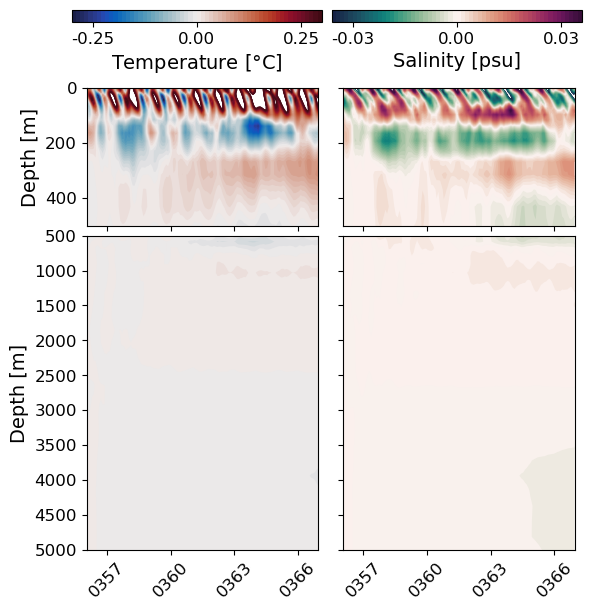

In [25]:
fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.3, 0.31, 0.01)

cf_temp = iplt.contourf(out, axes=ax[0],
                        levels = levels_temperature,
                        cmap = cm.balance)

iplt.contourf(out, axes = ax[2],
                        levels = levels_temperature,
                        cmap = cm.balance)

levels_salinity = np.arange(-0.03, 0.031, 0.001)

cf_salt = iplt.contourf(sal_hov, axes = ax[1],
                               levels = levels_salinity,
                               cmap = cm.curl)

iplt.contourf(sal_hov, axes = ax[3],
                     levels = levels_salinity,
                     cmap = cm.curl)
## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()